# CART(classification and regression trees)

## 1 create CART

In [1]:
import numpy as np
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine)) # map()是 Python 内置的高阶函数，它接收一个函数 f 和一个 list，
        # 并通过把函数 f 依次作用在 list 的每个元素上，得到一个新的 list 并返回。
        dataMat.append(fltLine)
    return dataMat

In [2]:
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[np.nonzero((dataSet[:, feature] > value))[0], :] #  Array filtering
    mat1 = dataSet[np.nonzero((dataSet[:, feature] <= value))[0], :]
    return mat0, mat1

In [3]:
testMat = np.mat(np.eye(4))
testMat

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [4]:
mat0, mat1 = binSplitDataSet(testMat, 1, 0.5)

In [5]:
mat0

matrix([[0., 1., 0., 0.]])

In [6]:
mat1

matrix([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

## calculate confusion

In [3]:
def regLeaf(dataSet):
    return np.mean(dataSet[:, -1]) # return current dataSet label mean value

In [4]:
def regErr(dataSet):
    return np.var(dataSet[:, -1]) * np.shape(dataSet)[0]

In [5]:
def ChoseBestSplit(dataSet, leafType = regLeaf, errType = regErr, ops = (1, 4)):
    tolS = ops[0] # tolerance on the target variables
    tolN = ops[1] # minimum data instance to include in a split
    if(len(set(dataSet[:, -1].T.tolist()[0])) == 1): # the first condition to generate a leaf node
        return None, leafType(dataSet) # in
    
    m, n = np.shape(dataSet)
    S = errType(dataSet)
    """find the lowest error of the sets after split"""
    bestS = np.inf
    bestIndex = 0
    bestValue = 0
    for featIndex in range(n - 1):
        for splitVal in set(dataSet[:, featIndex].T.tolist()[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):
                continue # if current classify is not fit
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:
                bestIndex = featIndex
                bestS = newS
                bestValue = splitVal
    if(S - bestS) < tolS:
        return None, leafType(dataSet) # the second condition to generate a leaf node
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if(np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):
        return None, leafType(dataSet) # the third condition to generate a leaf node
    return bestIndex, bestValue

In [6]:
def createTree(dataSet, leafType = regLeaf, errType = regErr, ops = (1, 4)):
    feat, val = ChoseBestSplit(dataSet, leafType, errType, ops)
    if feat == None:
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [12]:
myDat = loadDataSet('ex00.txt')
myMat = np.mat(myDat)
createTree(myMat)

{'spInd': 0,
 'spVal': 0.48813,
 'left': 1.0180967672413792,
 'right': -0.04465028571428572}

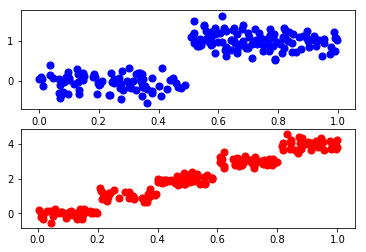

In [13]:
import matplotlib.pyplot as plt
myData1 = loadDataSet('ex0.txt')
myMat1 = np.mat(myData1)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(myMat[:, 0].flatten().A[0], myMat[:, 1].T.flatten().A[0], s = 50, c = 'b')
ax2.scatter(myMat1[:, 1].T.flatten().A[0], myMat1[:,2].T.flatten().A[0], s = 50, c = 'r')
plt.show()

In [13]:
createTree(myMat1)

{'spInd': 1,
 'spVal': 0.39435,
 'left': {'spInd': 1,
  'spVal': 0.582002,
  'left': {'spInd': 1,
   'spVal': 0.797583,
   'left': 3.9871632,
   'right': 2.9836209534883724},
  'right': 1.980035071428571},
 'right': {'spInd': 1,
  'spVal': 0.197834,
  'left': 1.0289583666666666,
  'right': -0.023838155555555553}}

## Merge the tree

In [7]:
def isTree(obj):
    return ((type(obj)).__name__ == 'dict')

In [8]:
def getMean(tree):
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    return (tree['left'] + tree['right']) / 2.0

In [9]:
def prune(tree, testData):
    if np.shape(testData)[0] == 0: # if the testData is NULL directly return tree's mean value
        return getMean(tree) 
    if (isTree(tree['right']) or isTree(tree['left'])): # if any tree is not NULL, split tree and merge
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'], lSet)
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'], rSet)
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        errorNoMerge = sum(np.power(lSet[:, -1] - tree['left'], 2)) + sum(np.power(rSet[:, -1] - tree['right'], 2))
        treeMean = (tree['left'] + tree['right']) / 2.0
        errorMerge = sum(np.power(testData[:, -1] - treeMean,2))
        if errorMerge < errorNoMerge:
            print("merging")
            return treeMean
        else:
            return tree
    else:
        return tree
    

In [17]:
myDatTest = loadDataSet('ex2test.txt')
myMatTest = np.mat(myDatTest)
myData2 = loadDataSet('ex2.txt')
myMat2 = np.mat(myData2)
myTree = createTree(myMat2, ops = (0, 1))
prune(myTree, myMatTest)

merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging


{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.729397,
  'left': {'spInd': 0,
   'spVal': 0.952833,
   'left': {'spInd': 0,
    'spVal': 0.965969,
    'left': 92.5239915,
    'right': {'spInd': 0,
     'spVal': 0.956951,
     'left': {'spInd': 0,
      'spVal': 0.958512,
      'left': {'spInd': 0,
       'spVal': 0.960398,
       'left': 112.386764,
       'right': 123.559747},
      'right': 135.837013},
     'right': 111.2013225}},
   'right': {'spInd': 0,
    'spVal': 0.759504,
    'left': {'spInd': 0,
     'spVal': 0.763328,
     'left': {'spInd': 0,
      'spVal': 0.769043,
      'left': {'spInd': 0,
       'spVal': 0.790312,
       'left': {'spInd': 0,
        'spVal': 0.806158,
        'left': {'spInd': 0,
         'spVal': 0.815215,
         'left': {'spInd': 0,
          'spVal': 0.833026,
          'left': {'spInd': 0,
           'spVal': 0.841547,
           'left': {'spInd': 0,
            'spVal': 0.841625,
            'left': {'spInd': 0,
            

# 2. modeling tree

In [10]:
def linearSolve(dataSet):
    m, n = np.shape(dataSet)
    X = np.mat(np.ones((m, n))) # include 1 constant create m * n matrix
    Y = np.mat(np.ones((m, 1))) # create m * 1 matrix
    X[:, 1 : n] = dataSet[:, 0 : n - 1]
    Y = dataSet[:, -1]
    xTx = X.T * X
    if np.linalg.det(xTx) == 0.0:
        raise NameError("This matrix is singular, cannot do inverse\n try increasing the second value of ops")
    ws = xTx.I * (X.T * Y)
    return ws, X, Y

In [11]:
def modelLeaf(dataSet):
    ws, X, Y = linearSolve(dataSet)
    return ws

In [12]:
def modelErr(dataSet):
    ws, X, Y = linearSolve(dataSet)
    yHat = X * ws
    return sum(np.power(yHat - Y, 2))

In [13]:
dataSet3 = loadDataSet('exp2.txt')
dataSetMat3 = np.mat(dataSet3)
myTree = createTree(dataSetMat3, modelLeaf, modelErr, (1, 10))
myTree

{'spInd': 0, 'spVal': 0.285477, 'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]), 'right': matrix([[3.46877936],
         [1.18521743]])}

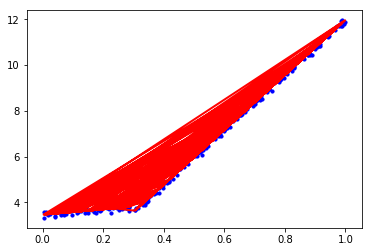

In [30]:
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(dataSetMat3[:, 0].flatten().A[0], dataSetMat3[:, 1].flatten().A[0], s = 10, c = 'b')
yHat = createForeCast(myTree, dataSetMat3[:, 0], modelTreeEval)
ax.plot(dataSetMat3[:, 0], yHat, linewidth = 2.0, c = 'r')
plt.show()

# 3. prdicte using model tree

In [14]:
def regTreeEval(model, inDat):
    return float(model)

In [15]:
def modelTreeEval(model, inDat):
    n = np.shape(inDat)[1] 
    X = np.mat(np.ones((1, n + 1)))
    X[:, 1 : n + 1] = inDat
    return X * model

In [16]:
def treeForeCast(tree, inData, modelEval = regTreeEval): # for a single data
    if not isTree(tree):
        return modelEval(tree, inData)
    if inData[tree['spInd']] > tree['spVal']: # if the data correspond data larger than mean value in left child tree
        if isTree(tree['left']):
            return treeForeCast(tree['left'], inData, modelEval)
        else:
            return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']):
            return treeForeCast(tree['right'], inData, modelEval)
        else:
            return modelEval(tree['right'], inData)

In [17]:
def createForeCast(tree, testData, modelEval = regTreeEval):
    m = len(testData)
    yHat = np.mat(np.zeros((m, 1)))
    for i in range(m):
        yHat[i, 0] = treeForeCast(tree, np.mat(testData[i]), modelEval)
    return yHat

In [35]:
""" create a regression tree """
trainMat = np.mat(loadDataSet('bikeSpeedVsIq_train.txt'))
testMat = np.mat(loadDataSet('bikeSpeedVsIq_test.txt'))
myTree = createTree(trainMat, ops = (1, 20))
yHat = createForeCast(myTree, testMat[:, 0])
np.corrcoef(yHat, testMat[:, 1], rowvar = 0)[0, 1]

0.9640852318222145

In [36]:
myTree2 = createTree(trainMat, modelLeaf, modelErr, (1, 20))
myTree2
yHat = createForeCast(myTree2, testMat[:, 0], modelTreeEval)
np.corrcoef(yHat, testMat[:, 1], rowvar = 0)[0, 1]

0.9760412191380623

In [37]:
ws, X, Y = linearSolve(trainMat) # linear regression
ws
for i in range(np.shape(testMat)[0]):
    yHat[i] = testMat[i, 0] * ws[1, 0] + ws[0, 0]
    #print(yHat[i])
np.corrcoef(yHat, testMat[:, 1], rowvar = 0)[0, 1]

0.9434684235674762

# 3. create gui

In [2]:
from tkinter import *
root = Tk()
myLabel = Label(root, text = "Hello World")
myLabel.grid()
root.mainloop()

In [18]:
import matplotlib
matplotlib.use('TkAgg') # 设置后端TkAgg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg # 将TkAgg和matplotlib连接起来
from matplotlib.figure import Figure # 图框

In [19]:
def reDraw(tolS, tolN):
    reDraw.f.clf() # 清空画布
    reDraw.a = reDraw.f.add_subplot(111) # 只有一个各自用于填充图形
    if chkBtnVar.get():
        if tolN < 2:
            tolN = 2
        myTree = createTree(reDraw.rawDat, modelLeaf, modelErr, (tolS, tolN))
        yHat = createForeCast(myTree, reDraw.testDat, modelTreeEval)
    else:
        myTree = createTree(reDraw.rawDat, ops = (tolS, tolN))
        yHat = createForeCast(myTree, reDraw.testDat)
    reDraw.a.scatter(np.array(reDraw.rawDat[:, 0]), np.array(reDraw.rawDat[:, 1]), s = 5)
    reDraw.a.plot(reDraw.testDat, yHat, linewidth = 2.0)
    reDraw.canvas.draw()

In [23]:
def getInputs():
    try: tolN = int(tolNentry.get())
    except:
        tolN = 10
        print("enter Integer for tolN")
        tolNentry.delete(0, END)
        tolNentry.insert(0, '10')
    try: tolS = int(tolNentry.get())
    except:
        tolS = 1.0
        print("enter Float for tolN")
        tolNentry.delete(0, END)
        tolNentry.insert(0, '1.0')
    return tolN, tolS

In [24]:
def drawNewTree():
    tolN, tolS = getInputs()
    reDraw(tolS, tolN)

In [25]:
from tkinter import *
root = Tk()

reDraw.f = Figure(figsize = (5, 4), dpi = 100)
reDraw.canvas = FigureCanvasTkAgg(reDraw.f, master = root)
reDraw.canvas.draw()
reDraw.canvas.get_tk_widget().grid(row = 0, columnspan = 3)

Label(root, text = "Plot Place Holder").grid(row = 0, columnspan = 3)
Label(root, text = "tolN").grid(row = 1, column = 0)
tolNentry = Entry(root)
tolNentry.grid(row = 1, column = 1)
tolNentry.insert(0, '10')

Label(root, text = "tolS").grid(row = 2, column = 0)
tolSentry = Entry(root)
tolSentry.grid(row = 2, column = 1)
tolSentry.insert(0, '1.0')
#按钮整数值用来读取checkbutton状态
Button(root, text = "ReDraw", command = drawNewTree).grid(row = 1, column = 2, rowspan = 3)
#添加复选框
chkBtnVar = IntVar()
chkBtn = Checkbutton(root, text = 'Model Tree', variable = chkBtnVar)
chkBtn.grid(row = 3, column = 0, columnspan = 2)
#读入数据
reDraw.rawDat = np.mat(loadDataSet('sine.txt'))
reDraw.testDat = np.arange(min(reDraw.rawDat[:, 0]), max(reDraw.rawDat[:, 0]), 0.01)
reDraw(1.0, 10)
#监听事件
root.mainloop()